# Quantifiers

The quantifiers are parameters calculated for each simulation that allows us to evaluate the characteristics of the colonie. The main characteristic are the four-cell organisation and the elongation of the colony.

The chosen quantifiers are :
- the aspect ratio $\alpha_r$.
- the density $\delta$.
- $s$ the mean of the difference between the distance the rest length of two disks.
- the distance $d_2$.

## Imports

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from PIL import Image
from skimage import measure
from skimage.io import imread
from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert
from scipy.ndimage import binary_fill_holes
from skimage.measure import EllipseModel
from numpy.linalg import norm
import random
import os
import sys

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1,r'C:\Users\fidac\Polytech\MAIN3\stage_bactéries\Bacteria')
import plot_model as pm

## Data loading and cleaning

In [88]:
file = "simuc10"
def convert(L):
    T = L.split(" ")
    T.pop()
    return list(np.array(T,dtype=float))

DF = pd.read_csv(file+".txt",sep="\t")

DF["X"]=DF["X"].apply(convert)
DF["time"] = DF["time"].apply(int)

df = DF.loc[DF["time"]==DF["time"].max()]
df = df.reset_index()

## 1. Calculating the aspect ratio

The aspect ratio refers to the elongation of the shape of the colony.
To calculate $\alpha_r$, we need to calculate the convex hull of the points of the colony and fit an ellipse on it. $\alpha_r$ is then defined as the ratio $\frac{l}{L}$ with $l$ the semi-minor axis and $L$ the semi-major axis.
<br>The aspect ratio equal 1 if the colony form a perfect circle

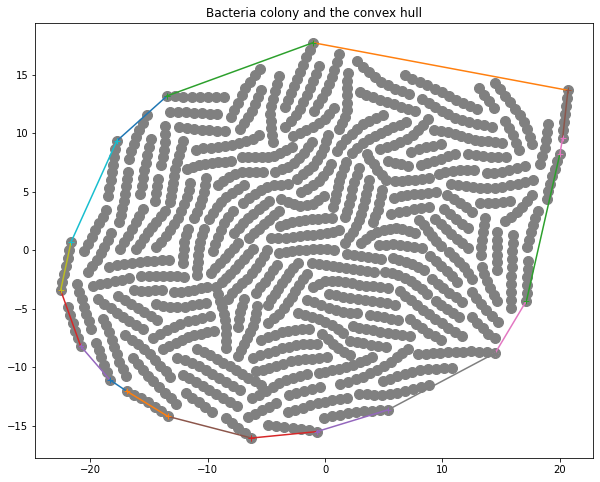

In [89]:
def convex_hull(df):
    """Returns two lists containing the points of the convex hull"""

    # Merge all the X datas
    X = []
    dfX = df["X"]
    for i in range(dfX.shape[0]):
        X = X + dfX[i]

    # Separates x and y
    x=X[0::2]
    y=X[1::2]

    # Converting the points to a compatible format for the Convexhull class
    points = np.array([x,y])
    points = np.transpose(points)

    x1 =[]
    y1 =[]
    
    if(df.shape[0]>1):
        # Calculating the hull
        hull = ConvexHull(points)

        # Calculating the vertices of the hull
        for i in hull.vertices:
            x1.append(x[i])
            y1.append(y[i])
        return x1,y1
    else:
        return [x[0],x[-1]],[y[0],y[-1]]

### Convex hull calculation for the maximum time
# Merge all the X datas
X = []
dfX = df["X"]
for i in range(dfX.shape[0]):
    X = X + dfX[i]

# Separates x and y
x=X[0::2]
y=X[1::2]

# Converting the points to a compatible format for the Convexhull class
points = np.array([x,y])
points = np.transpose(points)

x1 =[]
y1 =[]
if df.shape[0]!=1:
    # Calculating the hull
    hull = ConvexHull(points)

    # Calculating the vertices of the hull
    for i in hull.vertices:
        x1.append(x[i])
        y1.append(y[i])

    plt.figure(figsize=(10,8))
    plt.plot(points[:,0],points[:,1],".",color="grey",markersize=20)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], '+-',)
    plt.title("Bacteria colony and the convex hull")
    plt.show()
else :
    x1 = [x[0],x[-1]]
    y1 = [y[0],y[-1]]


aspect ratio = 0.7222144696553333


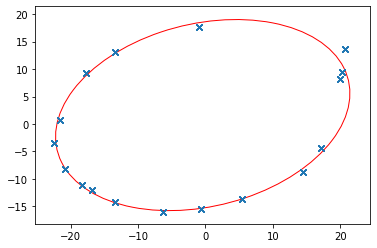

In [90]:
from matplotlib.patches import Ellipse

def aspect_ratio(df):
    """Returns the aspect ratio"""
    # Caculating the convex hull
    x,y = convex_hull(df)

    # Adding noise
    for i in range(0,len(x)):
        for j in range(0,10):
            x.append(x[i]+ random.uniform(0,0.001))
            y.append(y[i]+ random.uniform(0,0.001))
    
    points = np.array([x,y])
    points = points.transpose()

    # Calculating the ellipse
    ell = EllipseModel()
    ell.estimate(points)
    xc, yc, a, b, theta = ell.params

    if (a<b):
        return a/b,xc, yc, a, b, theta,x,y
    else:
        return b/a,xc, yc, a, b, theta,x,y
    

ar, xc, yc, a, b, theta,x,y = aspect_ratio(df)
ax = plt.gca()

print("aspect ratio =",ar)
plt.plot(x,y,"x")
ellipse = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')
ax.add_patch(ellipse)
plt.show()

## 2. Calculating the density

The density of the colony can be calculated by using image analysis tool.
The principle is to calculate the number of pixels that represents the bacteria and the number of pixels of the filled colony. The density is then the ration betaween these two values.
<br> The density equal 1 if the bacteria occupy all the space of the colony.

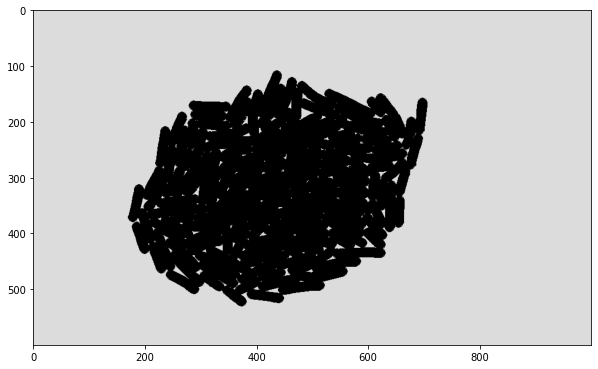

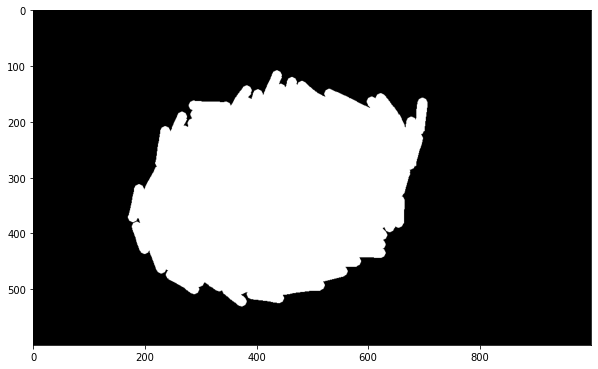

density= 0.9774944753880151


In [91]:
# Converting of array to binary
def gray_to_bin(im_array):
    """ Convert the image in greyscale to binary"""
    for i in range(im_array.shape[0]):
        for j in range(im_array.shape[1]):
            if im_array[i,j]!=1:
                im_array[i,j]=0

def identify_bact(tab):
    """Check if the pixel is part of a bacterium"""
    if tab[0]==0 and tab[1]==0 and tab[2]==0 :
        return True

def density(file,time):
    """Returns the density of a colony for a certain time"""

    # Creating the grey and black image
    Pm = pm.Plot(file + ".txt",time)
    Pm.save(1)

    # Loading the image
    image_path = "temp" + ".png"
    Img_array = imread(image_path)
    shape = Img_array.shape

    # Calculating the number of pixels of the bacterias
    nb_color = 0
    for i in range(shape[0]):
        for j in range(shape[1]):
            if identify_bact(Img_array[i,j,]):
                nb_color+=1
    
    # Inversing the colors
    Img_array = imread(image_path,as_gray=True)
    im =invert(Img_array)
    gray_to_bin(im)

    # Filling the holes
    filled = binary_fill_holes(im)

    # Calculating the area of the filled colony
    nb = 0
    shape = filled.shape
    for i in range(shape[0]):
        for j in range(shape[1]):
            if filled[i,j]==True:
                nb+=1

    os.remove("temp.png")
    return nb_color/nb

# Creating the grey and black image
mm = pm.Plot(file + ".txt")
mm.save(0)

# Loading and displaying the image
image_path = file + ".png"
Img_array = imread(image_path)
plt.figure(figsize=(10,8))
plt.imshow(Img_array)
plt.show()

shape = Img_array.shape

# Calculating the number of pixels of the bacterias
nb_color = 0
for i in range(shape[0]):
    for j in range(shape[1]):
        if identify_bact(Img_array[i,j,]):
            nb_color+=1

# Inversing the colors
Img_array = imread(image_path,as_gray=True)
im =invert(Img_array)

# Converting of array to binary
def gray_to_bin(im_array):
    """ Convert the image in greyscale to binary"""
    for i in range(im_array.shape[0]):
        for j in range(im_array.shape[1]):
            if im_array[i,j]!=1:
                im_array[i,j]=0

gray_to_bin(im)

# Filling the holes
filled = binary_fill_holes(im)
plt.figure(figsize=(10,8))
plt.imshow(filled,cmap=plt.cm.gray)
plt.show()

# Calculating the area of the filled colony
nb = 0
shape = filled.shape
for i in range(shape[0]):
    for j in range(shape[1]):
        if filled[i,j]==True:
            nb+=1

print("density=",nb_color/nb)

## 3. The length quantifier

The length quantifier quantifies the state of the hookean springs compared to their rest state.
<br>More $s$ is near to 0, more the springs are close to their equilibrum.

In [92]:
# Function to apply 
def qlength(X,l):
    """ Calculates the length quantifier """
    s = 0
    p_i = len(X)

    for i in range(0,p_i-3,2):
        s+= np.abs(norm(np.array([X[i+2],X[i+3]]) - np.array([X[i],X[i+1]]))-l)
    return s/(p_i-1)

def length_quantifier(df):
    """Returns the length quantifier s"""

    # Disks radius
    l = df["Disks radius"][0]
    # Calculating the mean for each bacterium
    mean_i = df["X"].apply(qlength,args=(l,))

    # Calculating the mean for all bacteria
    Ql = mean_i.mean()
    
    return Ql

print("Length quantifier = ",length_quantifier(df))


Length quantifier =  0.03301003167964621


## The  quantifiers as function the number of bacteria

Calculating the the quantifiers as functions of time and saving them as numpy files

In [93]:
times = DF["time"].drop_duplicates()
n = times.shape[0]

# quantifiers arrays
ar = np.zeros(n)
d = np.zeros(n)
s = np.zeros(n)

i=0
for time in times :
    cdf = DF.loc[DF["time"]==time]
    cdf = cdf.reset_index()
    
    print(time)
    ar[i],_,_,_,_,_,_,_ = aspect_ratio(cdf)
    d[i] = density(file,time)
    s[i] = length_quantifier(cdf)
    i +=1

np.save("./quantifiers_data/aspect_ratio/" + file + "_aspect_ratio.npy",ar)
np.save("./quantifiers_data/density/" + file + "_density.npy",d)
np.save("./quantifiers_data/length/" + file + "_length.npy",s)


3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183
186
189
192
195
198
200
